<a href="https://colab.research.google.com/github/ohmyghoz/Exercise-1/blob/master/Kaggle_Credit_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 #!pip install kaggle
 #!pip uninstall -y scikit-learn
 #!pip uninstall -y pandas
 #!pip uninstall -y pandas_ml

 #!pip install scikit-learn==0.21.1
 #!pip install pandas==0.24.2
 #!pip install pandas_ml

 #!pip3 install scikit-learn
 #!pip install optuna
 #!pip3 install sklearn_pandas
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
import xgboost as xgb
import optuna
import sklearn
from sklearn.metrics import accuracy_score
from yellowbrick.model_selection import feature_importances, FeatureImportances

import os
import zipfile


##**DATA UNDERSTANDING**

Source: https://www.kaggle.com/datasets/parisrohan/credit-score-classification

DATA UNDERSTANDING

1.	Customer_ID: Unique ID of the customer
2.	Month: Month of the year
3.	Name: The name of the person
4.	Age: The age of the person
5.	SSN: Social Security Number of the person
6.	Occupation: The occupation of the person
7.	Annual_Income: The Annual Income of the person
8.	Monthly_Inhand_Salary: Monthly in-hand salary of the person
9.	Num_Bank_Accounts: The number of bank accounts of the person
10.	Num_Credit_Card: Number of credit cards the person is having
11.	Interest_Rate: The interest rate on the credit card of the person
12.	Num_of_Loan: The number of loans taken by the person from the bank
13.	Type_of_Loan: The types of loans taken by the person from the bank
14.	Delay_from_due_date: The average number of days delayed by the person from the date of payment
15.	Num_of_Delayed_Payment: Number of payments delayed by the person
16.	Changed_Credit_Card: The percentage change in the credit card limit of the person
17.	Num_Credit_Inquiries: The number of credit card inquiries by the person
18.	Credit_Mix: Classification of Credit Mix of the customer
19.	Outstanding_Debt: The outstanding balance of the person
20.	Credit_Utilization_Ratio: The credit utilization ratio of the credit card of the customer
21.	Credit_History_Age: The age of the credit history of the person
22.	Payment_of_Min_Amount: Yes if the person paid the minimum amount to be paid only, otherwise no.
23.	Total_EMI_per_month: The total EMI per month of the person
24.	Amount_invested_monthly: The monthly amount invested by the person
25.	Payment_Behaviour: The payment behaviour of the person
26.	Monthly_Balance: The monthly balance left in the account of the person
27.	Credit_Score: The credit score of the person


Reference:
https://www.kaggle.com/code/clkmuhammed/credit-score-multi-class-classification-part-2-ml

##**STEP 01 : LOAD DATA USING KAGGLE API**

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'colabdevelop'
os.environ['KAGGLE_KEY'] = '327eeb915fe319d9167b84f0a1df68af'

%cd /content
!kaggle datasets download  -d parisrohan/credit-score-classification


with zipfile.ZipFile('credit-score-classification.zip', 'r') as file:
    file.extractall('creditscoring/')

/content
credit-score-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


##**STEP 02 : INVESTIGATE DATA (DATA TYPE, MISSING VALUES, CATEGORICAL DATA, NOISE)**

In [ ]:
df_train = pd.read_csv("creditscoring/train.csv")
df_test = pd.read_csv("creditscoring/test.csv")

print(df_train.shape, df_test.shape)
data = pd.concat([df_train, df_test], ignore_index=True)

display(data.shape)
display(data.info())
display(data.isnull().sum())

<ipython-input-32-5d3d1507cf12>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("creditscoring/train.csv")


(100000, 28) (50000, 27)


(150000, 28)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  object 
 3   Name                      135000 non-null  object 
 4   Age                       150000 non-null  object 
 5   SSN                       150000 non-null  object 
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  object 
 8   Monthly_Inhand_Salary     127500 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  int64  
 10  Num_Credit_Card           150000 non-null  int64  
 11  Interest_Rate             150000 non-null  int64  
 12  Num_of_Loan               150000 non-null  object 
 13  Type_of_Loan              132888 non-null  o

None

ID                              0
Customer_ID                     0
Month                           0
Name                        15000
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       22500
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                17112
Delay_from_due_date             0
Num_of_Delayed_Payment      10500
Changed_Credit_Limit            0
Num_Credit_Inquiries         3000
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age          13500
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      6750
Payment_Behaviour               0
Monthly_Balance              1762
Credit_Score                50000
dtype: int64



> ***`We can see that there are columns on which data types are not reflecting correct data types. E.g column Annual_Income is expected to be of float, it is recognized as 'object' instead. If we try to cast this column to numeric data type, it will return error. It is required to dig deeper to the values of this columns. `***

---





In [ ]:
#data.drop(columns='Name', inplace=True)
display(data.describe(exclude=np.number).T)

dtype_obj= data.describe(include='O').columns
display(dtype_obj)

# Convert the column to numeric and coerce non-convertible values to NaN
list_obj_num=['Annual_Income', 'Num_of_Loan','Num_of_Delayed_Payment', 'Changed_Credit_Limit','Outstanding_Debt', 'Age',
              'Amount_invested_monthly', 'Monthly_Balance']

for col in dtype_obj:
  if col in list_obj_num:
        print('Column Name: '+col)
        print("**"*20)
        numeric_column = pd.to_numeric(data[col], errors='coerce')
        non_convertible_values = data[col][numeric_column.isna()]
        print("Non-convertible values:")
        print(non_convertible_values)
        print('END', "--"*18, '\n')

,count,unique,top,freq
ID,150000,150000,0x1602,1
Customer_ID,150000,12500,CUS_0xd40,12
Month,150000,12,January,12500
Name,135000,10139,Stevex,66
Age,150000,2524,39,4198
SSN,150000,12501,#F%$D@*&8,8400
Occupation,150000,16,_______,10500
Annual_Income,150000,21192,36585.12,24
Num_of_Loan,150000,623,3,21500
Type_of_Loan,132888,6260,Not Specified,2112


Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Num_of_Loan', 'Type_of_Loan',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

Column Name: Age
****************************************
Non-convertible values:
8         28_
54        34_
58        30_
71        24_
89        33_
         ... 
149827    31_
149870    24_
149957    54_
149980    19_
149991    50_
Name: Age, Length: 7416, dtype: object
END ------------------------------------ 

Column Name: Annual_Income
****************************************
Non-convertible values:
10         34847.84_
27         30689.89_
32         35547.71_
56         34081.38_
66        114838.41_
             ...    
149903     14937.49_
149917      71025.4_
149918      71025.4_
149970     22620.79_
149977     38321.39_
Name: Annual_Income, Length: 10500, dtype: object
END ------------------------------------ 

Column Name: Num_of_Loan
****************************************
Non-convertible values:
37        0_
80        3_
84        3_
94        2_
119       5_
          ..
149952    0_
149966    4_
149976    4_
149996    2_
149998    2_
Name: Num_of_Loan, Length: 7221, 

In [ ]:
list_obj_category=['Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour','Occupation']
list_obj_num=['Annual_Income', 'Num_of_Loan','Num_of_Delayed_Payment', 'Changed_Credit_Limit','Outstanding_Debt', 'Age','Amount_invested_monthly', 'Monthly_Balance']

for col in list_obj_category:
  print (col)
  print (data[col].unique())
  print ('')

Credit_Mix
['_' 'Good' 'Standard' 'Bad']

Payment_of_Min_Amount
['No' 'NM' 'Yes']

Payment_Behaviour
['High_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'High_spent_Medium_value_payments' '!@9#%8'
 'High_spent_Large_value_payments']

Occupation
['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']



**Findings**
---
1. Some objects data type refers to categorical data types that requires numerical
representation:






*   Occupation
*   Type of Loan
*   Credit Mix
*   Payment of Min Amount
*   Payment Behaviour
*   Credit Score

2.  While the object that needs data type fixing:


*   Annual Income
*   Num of Loan
*   Num of Delayed Payment
*   Changed Credit Limit
*   Outstanding Debt
*   Age
*   Amount invested monthly
*   Monthly balance

3. Credit_History_Age can be converted to numbers.


4. Categorical values should be encoded.


##**STEP 03 : DATA PREPROCESSING**

In [ ]:

def text_cleaning(data):
    if data is np.NaN or not isinstance(data, str):
        return data
    else:
        return str(data).strip('_ ,"')

def impute_by_list(group,columns_to_impute, type):
    if type=='num':
      group[columns_to_impute]=df.groupby('Customer_ID',group_keys=False)[columns_to_impute].apply(lambda x:x.fillna(x.mean()))
    else:
      group[columns_to_impute]=df.groupby('Customer_ID',group_keys=False)[columns_to_impute].apply(lambda x:x.fillna(x.median()))

    return group

def encode_by_list(data,list_obj_category):
  label_encoder = LabelEncoder()
  for col in list_obj_category:
    data[col + '_encoded'] = label_encoder.fit_transform(data[col].astype(str))
    data.loc[data[col].isnull(), col + '_encoded'] = None

  return data


In [ ]:
#data cleaning convert to string and remove '_' from beginning and end.
data = data.applymap(text_cleaning).replace(['', 'nan','NaN', '!@9#%8', '#F%$D@*&8'], np.NaN)

for col in list_obj_num:
    data[col]=pd.to_numeric(data[col],errors='coerce')

#Transform credit_age_history to numerical
def Month_Converter(x):
    if pd.notnull(x):
        num1 = int(x.split(' ')[0])
        num2 = int(x.split(' ')[3])

        return (num1*12)+num2
    else:
        return x

data['Credit_History_Age_transformed'] = data.Credit_History_Age.apply(lambda x: Month_Converter(x)).astype(float)

#encode categorical objects
df=encode_by_list(data,list_obj_category)
display(df.isnull().sum())

#check categorical data after encoded
for col in list_obj_category:
  print (col+'_encoded')
  print (data[col+'_encoded'].unique())
  print ('')

ID                                    0
Customer_ID                           0
Month                                 0
Name                              15000
Age                                   0
SSN                                8400
Occupation                        10500
Annual_Income                         0
Monthly_Inhand_Salary             22500
Num_Bank_Accounts                     0
Num_Credit_Card                       0
Interest_Rate                         0
Num_of_Loan                           0
Type_of_Loan                      17112
Delay_from_due_date                   0
Num_of_Delayed_Payment            10500
Changed_Credit_Limit               3150
Num_Credit_Inquiries               3000
Credit_Mix                        30000
Outstanding_Debt                      0
Credit_Utilization_Ratio              0
Credit_History_Age                13500
Payment_of_Min_Amount                 0
Total_EMI_per_month                   0
Amount_invested_monthly            6750


Credit_Mix_encoded
[nan  1.  2.  0.]

Payment_of_Min_Amount_encoded
[1. 0. 2.]

Payment_Behaviour_encoded
[ 2.  3.  4.  5.  1. nan  0.]

Occupation_encoded
[12. nan 13.  4.  5.  2.  7. 10.  3.  6.  8.  0. 11.  9. 14.  1.]



In [ ]:
#Type of Loan is unique and need one hot encoding
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: x.lower().replace('and ', '').replace(', ', ',').strip() if pd.notna(x) else x)

print('Type of Loan')
print(df['Type_of_Loan'].unique())
print(df.shape)


df['Type_of_Loan'] = df['Type_of_Loan'].str.split(',').apply(lambda x: [] if isinstance(x, float) and np.isnan(x) else x)

# Flatten the lists and remove duplicates
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: list(set(x)))



# Use get_dummies to perform one-hot encoding on the flattened lists
one_hot_encoded = df['Type_of_Loan'].str.join(',').str.get_dummies(sep=',')
one_hot_encoded=one_hot_encoded.add_prefix('ToL_')
display(one_hot_encoded.columns)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)

# Drop the original 'loan_type' column
df = df.drop(columns=['Type_of_Loan'])


Type of Loan
['auto loan,credit-builder loan,personal loan,home equity loan'
 'credit-builder loan' 'auto loan,auto loan,not specified' ...
 'home equity loan,auto loan,auto loan,auto loan'
 'payday loan,student loan,mortgage loan,not specified'
 'personal loan,auto loan,mortgage loan,student loan,student loan']
(150000, 33)


Index(['ToL_auto loan', 'ToL_credit-builder loan',
       'ToL_debt consolidation loan', 'ToL_home equity loan',
       'ToL_mortgage loan', 'ToL_not specified', 'ToL_payday loan',
       'ToL_personal loan', 'ToL_student loan'],
      dtype='object')

In [ ]:
#remove unused columns
columns_to_drop=['ID','SSN','Month','Name','Credit_History_Age']
columns_to_drop.extend(list_obj_category)
df=df.drop(columns=columns_to_drop)

AFTER ENCODING, WE CAN AGAIN SPLIT DATA TO TRAIN AND TEST THEN IMPUTE ACCORDINGLY

In [ ]:
# train save
df_train=df[df['Credit_Score'].notna()]
# test save
df_test=df[df['Credit_Score'].isna()]

print ('Check null in train dataset:')
display(df_train.isnull().sum())

print('')
print ('Check null in test dataset:')
display(df_test.isnull().sum())

Check null in train dataset:


Customer_ID                           0
Age                                   0
Annual_Income                         0
Monthly_Inhand_Salary             15002
Num_Bank_Accounts                     0
Num_Credit_Card                       0
Interest_Rate                         0
Num_of_Loan                           0
Delay_from_due_date                   0
Num_of_Delayed_Payment             7002
Changed_Credit_Limit               2091
Num_Credit_Inquiries               1965
Outstanding_Debt                      0
Credit_Utilization_Ratio              0
Total_EMI_per_month                   0
Amount_invested_monthly            4479
Monthly_Balance                    1200
Credit_Score                          0
Credit_History_Age_transformed     9030
Credit_Mix_encoded                20195
Payment_of_Min_Amount_encoded         0
Payment_Behaviour_encoded          7600
Occupation_encoded                 7062
ToL_auto loan                         0
ToL_credit-builder loan               0



Check null in test dataset:


Customer_ID                           0
Age                                   0
Annual_Income                         0
Monthly_Inhand_Salary              7498
Num_Bank_Accounts                     0
Num_Credit_Card                       0
Interest_Rate                         0
Num_of_Loan                           0
Delay_from_due_date                   0
Num_of_Delayed_Payment             3498
Changed_Credit_Limit               1059
Num_Credit_Inquiries               1035
Outstanding_Debt                      0
Credit_Utilization_Ratio              0
Total_EMI_per_month                   0
Amount_invested_monthly            2271
Monthly_Balance                     562
Credit_Score                      50000
Credit_History_Age_transformed     4470
Credit_Mix_encoded                 9805
Payment_of_Min_Amount_encoded         0
Payment_Behaviour_encoded          3800
Occupation_encoded                 3438
ToL_auto loan                         0
ToL_credit-builder loan               0


In [ ]:
df_train[['Customer_ID','Age', 'Annual_Income','ToL_auto loan', 'ToL_credit-builder loan',
       'ToL_debt consolidation loan', 'ToL_home equity loan',
       'ToL_mortgage loan', 'ToL_not specified', 'ToL_payday loan',
       'ToL_personal loan', 'ToL_student loan']]

,Customer_ID,Age,Annual_Income,ToL_auto loan,ToL_credit-builder loan,ToL_debt consolidation loan,ToL_home equity loan,ToL_mortgage loan,ToL_not specified,ToL_payday loan,ToL_personal loan,ToL_student loan
0,CUS_0xd40,23,19114.12,1,1,0,1,0,0,0,1,0
1,CUS_0xd40,23,19114.12,1,1,0,1,0,0,0,1,0
2,CUS_0xd40,-500,19114.12,1,1,0,1,0,0,0,1,0
3,CUS_0xd40,23,19114.12,1,1,0,1,0,0,0,1,0
4,CUS_0xd40,23,19114.12,1,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CUS_0x942c,25,39628.99,1,0,0,0,0,0,0,0,1
99996,CUS_0x942c,25,39628.99,1,0,0,0,0,0,0,0,1
99997,CUS_0x942c,25,39628.99,1,0,0,0,0,0,0,0,1
99998,CUS_0x942c,25,39628.99,1,0,0,0,0,0,0,0,1


In [ ]:
#impute train and test set

# Apply the imputation function to each group, passing columns_to_impute as a parameter
columns_to_impute_num=['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Age_transformed']
columns_to_impute_encode=['Credit_Mix_encoded', 'Payment_of_Min_Amount_encoded', 'Payment_Behaviour_encoded', 'Occupation_encoded', 'ToL_auto loan', 'ToL_credit-builder loan',
       'ToL_debt consolidation loan', 'ToL_home equity loan',
       'ToL_mortgage loan', 'ToL_not specified', 'ToL_payday loan',
       'ToL_personal loan', 'ToL_student loan']

df_train=impute_by_list(df_train,columns_to_impute_num,'num')
df_train=impute_by_list(df_train,columns_to_impute_encode,'encode')

df_test=impute_by_list(df_test,columns_to_impute_num,'num')
df_test=impute_by_list(df_test,columns_to_impute_encode,'encode')

print ('Check null in train dataset:')
display(df_train.isnull().sum())

print('')
print ('Check null in test dataset:')
display(df_test.isnull().sum())

#df_test=df_test.drop(columns='Credit_Score')

<ipython-input-35-cd6b7647f903>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[columns_to_impute]=df.groupby('Customer_ID',group_keys=False)[columns_to_impute].apply(lambda x:x.fillna(x.mean()))
<ipython-input-35-cd6b7647f903>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[columns_to_impute]=df.groupby('Customer_ID',group_keys=False)[columns_to_impute].apply(lambda x:x.fillna(x.median()))
<ipython-input-35-cd6b7647f903>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Check null in train dataset:


<ipython-input-35-cd6b7647f903>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[columns_to_impute]=df.groupby('Customer_ID',group_keys=False)[columns_to_impute].apply(lambda x:x.fillna(x.median()))


Customer_ID                       0
Age                               0
Annual_Income                     0
Monthly_Inhand_Salary             0
Num_Bank_Accounts                 0
Num_Credit_Card                   0
Interest_Rate                     0
Num_of_Loan                       0
Delay_from_due_date               0
Num_of_Delayed_Payment            0
Changed_Credit_Limit              0
Num_Credit_Inquiries              0
Outstanding_Debt                  0
Credit_Utilization_Ratio          0
Total_EMI_per_month               0
Amount_invested_monthly           0
Monthly_Balance                   0
Credit_Score                      0
Credit_History_Age_transformed    0
Credit_Mix_encoded                0
Payment_of_Min_Amount_encoded     0
Payment_Behaviour_encoded         0
Occupation_encoded                0
ToL_auto loan                     0
ToL_credit-builder loan           0
ToL_debt consolidation loan       0
ToL_home equity loan              0
ToL_mortgage loan           


Check null in test dataset:


Customer_ID                           0
Age                                   0
Annual_Income                         0
Monthly_Inhand_Salary                 0
Num_Bank_Accounts                     0
Num_Credit_Card                       0
Interest_Rate                         0
Num_of_Loan                           0
Delay_from_due_date                   0
Num_of_Delayed_Payment                0
Changed_Credit_Limit                  0
Num_Credit_Inquiries                  0
Outstanding_Debt                      0
Credit_Utilization_Ratio              0
Total_EMI_per_month                   0
Amount_invested_monthly               0
Monthly_Balance                       0
Credit_Score                      50000
Credit_History_Age_transformed        0
Credit_Mix_encoded                    0
Payment_of_Min_Amount_encoded         0
Payment_Behaviour_encoded             0
Occupation_encoded                    0
ToL_auto loan                         0
ToL_credit-builder loan               0


In [ ]:
df_test=df_test.drop(columns=['Credit_Score','Customer_ID'])
df_train=df_train.drop(columns=['Customer_ID'])

df_train.shape,df_test.shape

((100000, 31), (50000, 30))

##**Explore the pre-processed data**

Age
Annual_Income
Monthly_Inhand_Salary
Num_Bank_Accounts
Num_Credit_Card
Interest_Rate
Num_of_Loan
Delay_from_due_date
Num_of_Delayed_Payment
Changed_Credit_Limit
Num_Credit_Inquiries
Outstanding_Debt
Credit_Utilization_Ratio
Total_EMI_per_month
Amount_invested_monthly
Monthly_Balance
Credit_History_Age_transformed


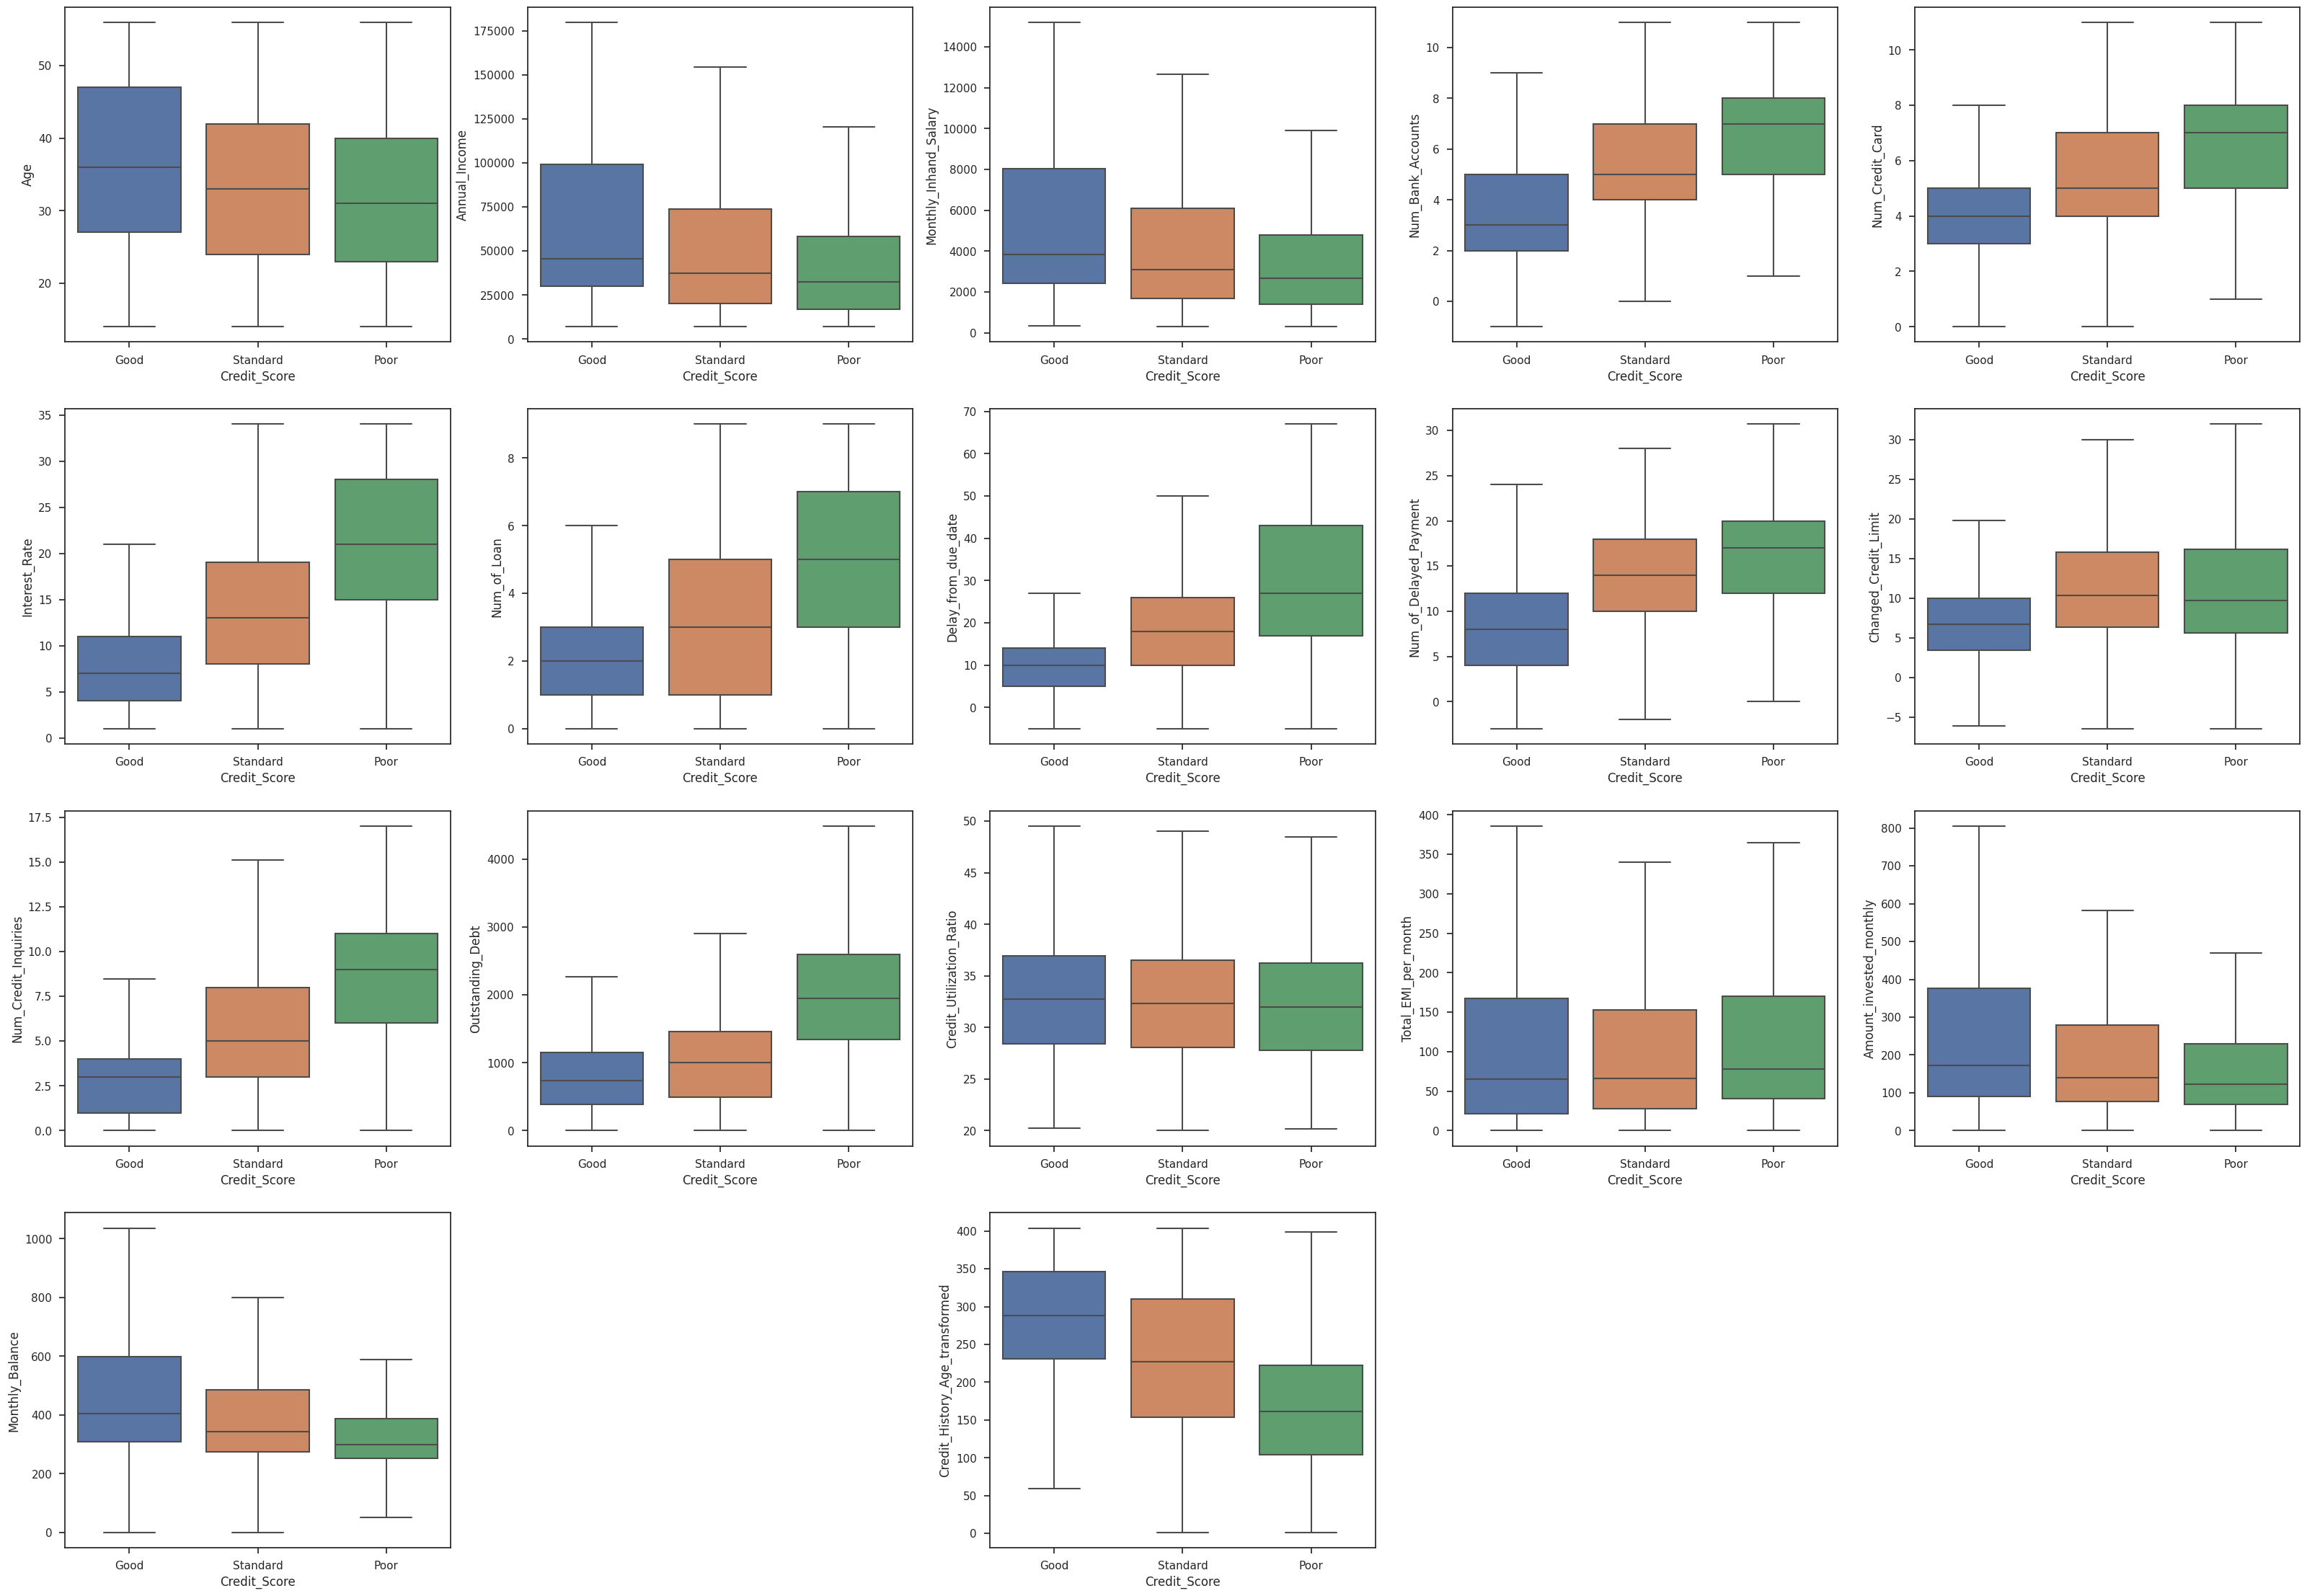

In [ ]:
sns.set(style="ticks")
%matplotlib inline

plt.figure(figsize=(40,35))
filtered_columns=[col for col in df_train.columns if (not col.startswith('ToL_') and not col.endswith('_encoded'))]
filtered_columns.extend(['Credit_Score','ID'])
for i, c in enumerate(filtered_columns, 1):
    if c not in ['Credit_Score','ID']:
        print(c)
        plt.subplot(5,5,i)
        g = sns.boxplot(x="Credit_Score", y=c, data=df_train, sym='')
        #g.set(yscale="log")


In [ ]:
category_order = ['Poor', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[category_order])

# Create a DataFrame from the encoded size
# Fit and transform the encoder on the 'Size' column
encoded_credit_score = encoder.fit_transform(df_train[['Credit_Score']])
encoded_df = pd.DataFrame(encoded_credit_score, columns=['Credit_Score_encoded'])

# Concatenate the encoded DataFrame with the original DataFrame
df_train = pd.concat([df_train, encoded_df], axis=1)


##**STEP 04 : BUILD MODEL**

In [ ]:
random_state=42

X = df_train.drop(columns=["Credit_Score",'Credit_Score_encoded'])
y = df_train['Credit_Score_encoded']
X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=random_state)


scaler =MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((75000, 30), (75000,), (25000, 30), (25000,), (50000, 30))

In [ ]:
def eval(model, X_train, X_val, y_train=y_train, y_val=y_val):
    print('TEST')
    y_val_pred = model.predict(X_val)
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))
    print("-------------------------------------------------------")
    print('TRAIN')
    y_train_pred = model.predict(X_train)
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

##**Experimenting multiple algorithms and methods**
1. Random Forest , XGBoost
2. Dimensionality Reduction (PCA)
3. Parameter tuning
4. Feature Importance

In [ ]:
#overfitting sample
sample_weight = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pd.unique(sample_weight)

# Create a Random Forest classifier
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train,sample_weight=sample_weight)
print("RF MODEL")
eval(rfc, X_train, X_val)

RF MODEL
TEST
[[ 5995  1277    41]
 [ 1517 10848   900]
 [   22  1138  3262]]
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81      7313
         1.0       0.82      0.82      0.82     13265
         2.0       0.78      0.74      0.76      4422

    accuracy                           0.80     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.80      0.80     25000

-------------------------------------------------------
TRAIN
[[21684     1     0]
 [    0 39909     0]
 [    0     0 13406]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21685
         1.0       1.00      1.00      1.00     39909
         2.0       1.00      1.00      1.00     13406

    accuracy                           1.00     75000
   macro avg       1.00      1.00      1.00     75000
weighted avg       1.00      1.00      1.00     75000



XGB MODEL
TEST
[[5890  832  591]
 [2256 8763 2246]
 [  76  571 3775]]
              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76      7313
         1.0       0.86      0.66      0.75     13265
         2.0       0.57      0.85      0.68      4422

    accuracy                           0.74     25000
   macro avg       0.72      0.77      0.73     25000
weighted avg       0.77      0.74      0.74     25000

-------------------------------------------------------
TRAIN
[[18855  1667  1163]
 [ 5834 27826  6249]
 [   94  1130 12182]]
              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81     21685
         1.0       0.91      0.70      0.79     39909
         2.0       0.62      0.91      0.74     13406

    accuracy                           0.78     75000
   macro avg       0.76      0.83      0.78     75000
weighted avg       0.81      0.78      0.79     75000



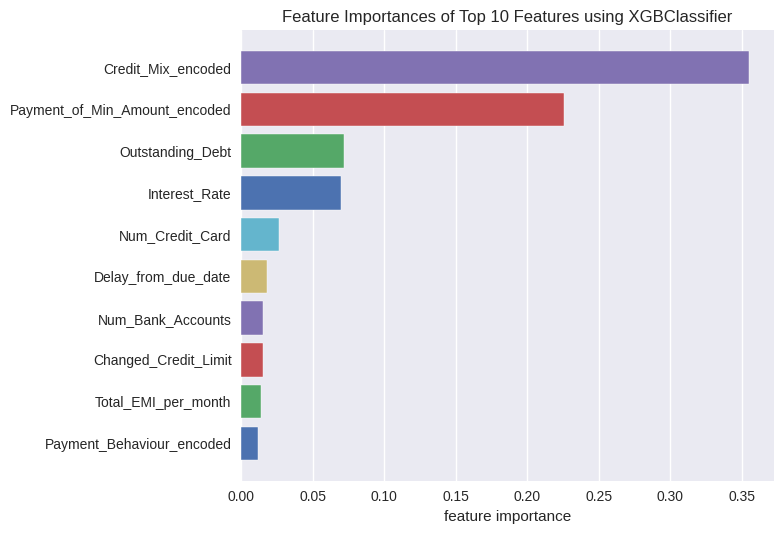

['Payment_Behaviour_encoded' 'Total_EMI_per_month' 'Changed_Credit_Limit'
 'Num_Bank_Accounts' 'Delay_from_due_date' 'Num_Credit_Card'
 'Interest_Rate' 'Outstanding_Debt' 'Payment_of_Min_Amount_encoded'
 'Credit_Mix_encoded']


In [ ]:
from xgboost import XGBClassifier


xgb_std = XGBClassifier(
    random_state=random_state,
)

xgb_std.fit(X_train, y_train,
    sample_weight=sample_weight
)

print("XGB MODEL")
eval(xgb_std, X_train, X_val)

viz = feature_importances(xgb_std, X_train, y_val, relative=False, topn=10)

# get top 10 features
print(viz.features_)

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
       'Credit_Score', 'Credit_History_Age_transformed', 'Credit_Mix_encoded',
       'Payment_of_Min_Amount_encoded', 'Payment_Behaviour_encoded',
       'Occupation_encoded', 'ToL_auto loan', 'ToL_credit-builder loan',
       'ToL_debt consolidation loan', 'ToL_home equity loan',
       'ToL_mortgage loan', 'ToL_not specified', 'ToL_payday loan',
       'ToL_personal loan', 'ToL_student loan', 'Credit_Score_encoded'],
      dtype='object')


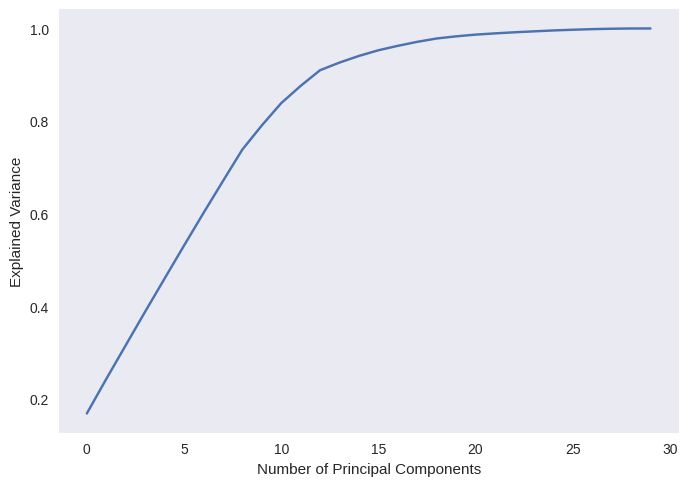

In [ ]:
print(df_train.columns)

pca=PCA()
comp = pca.fit(X_train_scaled)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();



In [ ]:
pca = PCA(n_components=0.95).fit(X_train_scaled)
train_x_transform = pca.transform(X_train_scaled)

# Transform the validation set
valid_x_transform = pca.transform(X_val_scaled)

In [ ]:

xgb_pca = XGBClassifier(
    random_state=random_state,
)

xgb_pca.fit(train_x_transform, y_train,
    sample_weight=sample_weight
)

print("XGB MODEL")
eval(xgb_pca, train_x_transform, valid_x_transform)

XGB MODEL
TEST
[[5265  956 1092]
 [2905 7759 2601]
 [ 104  638 3680]]
              precision    recall  f1-score   support

         0.0       0.64      0.72      0.68      7313
         1.0       0.83      0.58      0.69     13265
         2.0       0.50      0.83      0.62      4422

    accuracy                           0.67     25000
   macro avg       0.66      0.71      0.66     25000
weighted avg       0.71      0.67      0.67     25000

-------------------------------------------------------
TRAIN
[[16777  1805  3103]
 [ 7435 24790  7684]
 [  215  1430 11761]]
              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73     21685
         1.0       0.88      0.62      0.73     39909
         2.0       0.52      0.88      0.65     13406

    accuracy                           0.71     75000
   macro avg       0.70      0.76      0.70     75000
weighted avg       0.76      0.71      0.72     75000



##**Experimenting Hyperparameter Tuning**

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_x_transform, label=y_train)
dvalid = xgb.DMatrix(valid_x_transform, label=y_val)
# The objective function is passed an Optuna specific argument of trial
def objective(trial):

# params specifies the XGBoost hyperparameters to be tuned
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',     # Multi-class log loss for early stopping
        'num_class': 3,      # Number of classes in your dataset
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.50, 1),
        'alpha': trial.suggest_float('alpha', 0, 1),   # L1 regularization (Lasso)
        'lambda': trial.suggest_float('lambda', 0, 1),  # L2 regularization (Ridge)
        'tree_method': 'auto'
    }

    bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dvalid, 'eval')],
                    early_stopping_rounds=10, verbose_eval=False)
    preds = bst.predict(dvalid, ntree_limit=bst.best_iteration)
    pred_labels = np.rint(preds)

# trials will be evaluated based on their accuracy on the test set
    accuracy = sklearn.metrics.accuracy_score(y_val, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
#for key, value in trial.params.items():
    #print("    {}: {}".format(key, value))

[I 2023-09-24 23:27:31,045] A new study created in memory with name: no-name-c1f634c8-83c9-47fb-b84a-5631c3705c2c
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
[I 2023-09-24 23:28:23,513] Trial 0 finished with value: 0.70876 and parameters: {'max_depth': 15, 'learning_rate': 0.2821802095675463, 'subsample': 0.5507268539739123, 'colsample_bytree': 0.5998086717241896, 'alpha': 0.11405240029046959, 'lambda': 0.9395769256673441}. Best is trial 0 with value: 0.70876.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
[I 2023-09-24 23:30:40,732] Trial 1 finished with value: 0.7212 and parameters: {'max_depth': 13, 'learning_rate': 0.14166911984032013, 'subsample': 0.9797496433358173, 'colsample_bytree': 0.6580015494982805, 'alpha': 0.7920772782914985, 'lambda':

Number of finished trials:  5
Best trial:
  Value: 0.7288
  Params: 


In [ ]:
best_params = trial.params
optimal_xgb_pca = xgb.XGBClassifier(**best_params)


optimal_xgb_pca.fit(train_x_transform, y_train)
eval(optimal_xgb_pca, train_x_transform, valid_x_transform)

TEST
[[ 4811  1983   519]
 [ 1609 10195  1461]
 [   73  1335  3014]]
              precision    recall  f1-score   support

         0.0       0.74      0.66      0.70      7313
         1.0       0.75      0.77      0.76     13265
         2.0       0.60      0.68      0.64      4422

    accuracy                           0.72     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.72      0.72      0.72     25000

-------------------------------------------------------
TRAIN
[[19086  1773   826]
 [ 1482 36902  1525]
 [   53  1620 11733]]
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90     21685
         1.0       0.92      0.92      0.92     39909
         2.0       0.83      0.88      0.85     13406

    accuracy                           0.90     75000
   macro avg       0.89      0.89      0.89     75000
weighted avg       0.90      0.90      0.90     75000



##**Experimenting Hyperparameter Tuning only on selected features**

In [ ]:
#use only top10 features
top_features=['Payment_Behaviour_encoded', 'Total_EMI_per_month', 'Changed_Credit_Limit',
 'Num_Bank_Accounts', 'Delay_from_due_date' ,'Num_Credit_Card',
 'Interest_Rate' ,'Outstanding_Debt', 'Payment_of_Min_Amount_encoded',
 'Credit_Mix_encoded']

X_train_feat=X_train[top_features]
X_val_feat=X_val[top_features]

dtrain = xgb.DMatrix(X_train_feat, label=y_train)
dvalid = xgb.DMatrix(X_val_feat, label=y_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
#for key, value in trial.params.items():
    #print("    {}: {}".format(key, value))

best_params = trial.params
optimal_xgb = xgb.XGBClassifier(**best_params)


optimal_xgb.fit(X_train_feat, y_train)
eval(optimal_xgb, X_train_feat, X_val_feat)

[I 2023-09-24 23:47:58,539] A new study created in memory with name: no-name-30ff9b40-0e1b-4ed9-95f8-b19c32be2a85
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
[I 2023-09-24 23:48:50,222] Trial 0 finished with value: 0.72176 and parameters: {'max_depth': 6, 'learning_rate': 0.04625810949716281, 'subsample': 0.7999508326558595, 'colsample_bytree': 0.7681365595662459, 'alpha': 0.4138708739257847, 'lambda': 0.797053328319735}. Best is trial 0 with value: 0.72176.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
[I 2023-09-24 23:50:22,261] Trial 1 finished with value: 0.77864 and parameters: {'max_depth': 11, 'learning_rate': 0.03761425097107328, 'subsample': 0.5674601510071688, 'colsample_bytree': 0.8464352077450272, 'alpha': 0.22126319933062089, 'lambda':

Number of finished trials:  12
Best trial:
  Value: 0.79772
  Params: 
TEST
[[ 5837  1361   115]
 [ 1516 10684  1065]
 [   13  1101  3308]]
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80      7313
         1.0       0.81      0.81      0.81     13265
         2.0       0.74      0.75      0.74      4422

    accuracy                           0.79     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.79      0.79      0.79     25000

-------------------------------------------------------
TRAIN
[[19706  1884    95]
 [ 2791 35444  1674]
 [    4  1486 11916]]
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89     21685
         1.0       0.91      0.89      0.90     39909
         2.0       0.87      0.89      0.88     13406

    accuracy                           0.89     75000
   macro avg       0.89      0.90      0.89     75000
weighted avg       0.89    

<ipython-input-76-e4ef253c62fc>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


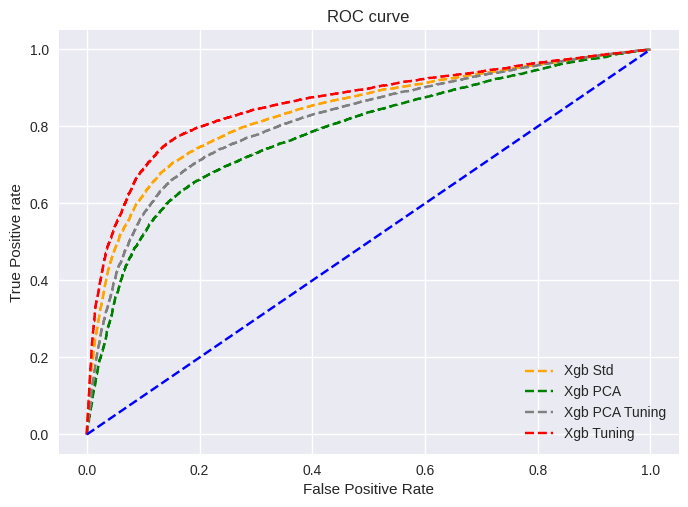

In [ ]:
# predict probabilities
pred_prob1 = xgb_std.predict_proba(X_val)
pred_prob2 = xgb_pca.predict_proba(valid_x_transform)
pred_prob3 = optimal_xgb_pca.predict_proba(valid_x_transform)
pred_prob4 = optimal_xgb.predict_proba(X_val_feat)

from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_val, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_val, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_val, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_val, pred_prob4[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Xgb Std')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Xgb PCA')
plt.plot(fpr3, tpr3, linestyle='--',color='grey', label='Xgb PCA Tuning')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='Xgb Tuning')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();